Building the Upstream using raw ACE and Wind Data and Comparing it to OMNI and Artemis and seeing if we are better than NASA.

Packages

In [1]:
# region <Importing Packages>
import datetime as dt

import pandas as pd
import pyspedas
#from pyqtgraph.graphicsItems.PlotDataItem import dataType
from pyspedas import tplot
import matplotlib.pyplot as plt
from pytplot import get_data
#import pandas as pd
import numpy as np
# endregion

24-Nov-25 00:31:41: C:\Users\Brian\anaconda3\envs\Research_Espen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



Importing Data (ACE, Wind, OMNI)

In [3]:

#This is where you input where to start and stop
start = "2016-05-06/12:00:00"
stop = "2016-05-07/11:59:59"

#This code allows us to shift the start a couple of hours back.
sec = 5400
date_start = pd.to_datetime(start)
shift = pd.Timedelta(sec, unit='s')
ts = date_start-shift
shifted_start = ts.strftime('%Y-%m-%d %H:%M:%S')


In [26]:
# region <Importing OMNI Data>
#This code allows us to get data from OMNI.

pyspedas.projects.omni.data(trange=[start, stop], datatype='1min', level='hro2', time_clip=True)
omni = pd.DataFrame({
    'Time': get_data('BZ_GSM')[0],
    'BY': get_data('BY_GSM')[1],
    'BZ': get_data('BZ_GSM')[1],
    'IMF': get_data('IMF')[1],
    "ts": get_data('Timeshift')[1],
    'VX': get_data('Vx')[1],
    'VY': get_data('Vy')[1],
    'VZ': get_data('Vz')[1],
    'Density': get_data('proton_density')[1],
    'Temp': get_data('T')[1],
    'X': get_data('x')[1],
})

#The data will then be interpolated to 1 minute intervals
omni['Time'] = pd.to_datetime(omni['Time'], unit='s')
omni = omni.set_index('Time')
omni = omni.resample('min').mean().interpolate(method='linear').ffill().bfill()
omni = omni.reset_index()
# endregion

24-Nov-25 00:51:05: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro2_1min/2016/
24-Nov-25 00:51:16: Remote index took 10.6 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 00:51:17: File is current: omni_data/hro2_1min/2016/omni_hro2_1min_20160501_v01.cdf


In [59]:
# region <Importing ACE Data>
#This code allows us to get data from ACE.

pyspedas.projects.ace.mfi(trange=[shifted_start, stop], datatype='h3', time_clip=True)
ace = pd.DataFrame({
    'Time': get_data('BGSM')[0],
    'BX': get_data('BGSM')[1][:,0],
    'BY': get_data('BGSM')[1][:,1],
    'BZ': get_data('BGSM')[1][:,2],
    'VX': get_data('V_GSM')[1][:,0],
    'VY': get_data('V_GSM')[1][:,1],
    'VZ': get_data('V_GSM')[1][:,2],
    "Np": get_data('Np')[1],
    "X": get_data('SC_pos_GSM')[1],
    "Temp": get_data('Tpr')[1],

},columns = ['Time','BX','BY','BZ']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
ace['Time'] = pd.to_datetime(ace['Time'], unit='s')
ace = ace.set_index('Time')
ace = ace.resample('s').mean().interpolate(method='linear').ffill()
ace = ace.reset_index()
# endregion

24-Nov-25 01:18:20: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2016/
24-Nov-25 01:18:31: Remote index took 10.8 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 01:18:32: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160506_v02.cdf
24-Nov-25 01:18:44: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160507_v02.cdf
24-Nov-25 01:18:51: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/
24-Nov-25 01:19:01: Remote index took 10.7 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 01:19:03: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf
24-Nov-25 01:19:14: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf


In [92]:
pyspedas.projects.ace.swe(trange=[shifted_start, stop],datatype='h0', time_clip=True)
ace2 = pd.DataFrame({
    'Time': get_data('V_GSM')[0],
    'VX': get_data('V_GSM')[1][:,0],
    'VY': get_data('V_GSM')[1][:,1],
    'VZ': get_data('V_GSM')[1][:,2],
    "NP": get_data('Np')[1],
    "X": get_data('SC_pos_GSM')[1][:,0],
    "Temp": get_data('Tpr')[1],

},columns = ['Time','VX','VY','VZ','NP','X','Temp']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
ace2['Time'] = pd.to_datetime(ace2['Time'], unit='s')
ace2 = ace2.set_index('Time')
ace2 = ace2.resample('s').mean().interpolate(method='linear').ffill()
ace2 = ace2.reset_index()

24-Nov-25 01:49:27: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/
24-Nov-25 01:49:37: Remote index took 10.8 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 01:49:38: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf
24-Nov-25 01:49:50: File is current: ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf


In [127]:
pyspedas.projects.wind.mfi(trange=[shifted_start, stop], datatype='h0', time_clip=True)

24-Nov-25 02:09:06: File is current: wind_data/wind_masters/wi_h0_mfi_00000000_v01.cdf
24-Nov-25 02:09:06: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2016/
24-Nov-25 02:09:17: Remote index took 11.1 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 02:09:18: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160506_v05.cdf
24-Nov-25 02:09:30: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160507_v05.cdf


['BF1',
 'BRMSF1',
 'BGSM',
 'BRMSGSM',
 'BGSE',
 'BRMSGSE',
 'DIST',
 'PGSM',
 'PGSE',
 'B3F1',
 'B3RMSF1',
 'B3GSM',
 'B3RMSGSM',
 'B3GSE',
 'B3RMSGSE',
 'B1F1',
 'B1RMSF1',
 'B1GSM',
 'B1RMSGSM',
 'B1GSE',
 'B1RMSGSE',
 'DIST1',
 'P1GSM',
 'P1GSE']

In [74]:
# region <Importing WIND Data>
#This code allows us to get data from Wind.
pyspedas.projects.wind.mfi(trange=[shifted_start, stop], datatype='h0', time_clip=True)
wind = pd.DataFrame({
    'Time': get_data('B3GSM')[0],
    'BX': get_data('B3GSM')[1][:,0],
    'BY': get_data('B3GSM')[1][:,1],
    'BZ': get_data('B3GSM')[1][:,2],

}, columns = ['Time','BX','BY', 'BZ']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
wind['Time'] = pd.to_datetime(wind['Time'], unit='s')
wind = wind.set_index('Time')
wind = wind.resample('s').mean().interpolate(method='linear').ffill()
wind = wind.reset_index()
# endregion

24-Nov-25 01:38:15: File is current: wind_data/wind_masters/wi_h0_mfi_00000000_v01.cdf
24-Nov-25 01:38:15: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2016/
24-Nov-25 01:38:27: Remote index took 11.3 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 01:38:28: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160506_v05.cdf
24-Nov-25 01:38:40: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160507_v05.cdf


In [124]:
pyspedas.projects.wind.swe(trange=[shifted_start,stop], datatype='k0', varnames=[], time_clip=True)
wind2 = pd.DataFrame({
    'Time': get_data('V_GSM')[0],
    'X': get_data('SC_pos_GSM')[1][:,0],
    'VX': get_data('V_GSM')[1][:,0],
    'VY': get_data('V_GSM')[1][:,1],
    'VZ': get_data('V_GSM')[1][:,2],
    "NP": get_data('Np')[1],
    'Temp':get_data('THERMAL_SPD')[1],

}, columns = ['Time','X','VX', 'VY','VZ','NP','Temp']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
wind2['Time'] = pd.to_datetime(wind2['Time'], unit='s')
wind2 = wind2.set_index('Time')
wind2 = wind2.resample('s').mean().interpolate(method='linear').ffill()
wind2 = wind2.reset_index()


24-Nov-25 02:06:30: File is current: wind_data/wind_masters/wi_k0_swe_00000000_v01.cdf
24-Nov-25 02:06:30: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_k0/2016/
24-Nov-25 02:06:41: Remote index took 10.9 seconds to return, may indicate problems on remote server (index_slow)
24-Nov-25 02:06:42: File is current: wind_data/swe/swe_k0/2016/wi_k0_swe_20160506_v02.cdf
24-Nov-25 02:06:54: File is current: wind_data/swe/swe_k0/2016/wi_k0_swe_20160507_v02.cdf


Getting Upstream data

In [94]:

upstream_time = []
shift = []
upstream_bx = []
upstream_by = []
upstream_bz = []
upstream_vx = []
upstream_vy = []
upstream_vz = []
upstream_np = []
upstream_x = []

pt_ID = []
for i in range(len(omni['IMF'])):
    delta = pd.Timedelta(omni['ts'][i], unit='s')
    time = omni['Time'][i] - delta
    shift.append(delta)


    match omni['IMF'][i]:

        #If the spacecraft ID is 71, get the data from ace.
        case 71:
            ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
            ind2 = ace2.loc[ace2['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if ace doesn't have the data, get the data from wind
            if np.isnan(ace['BZ'][ind]):
                print("found a nan")
                ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
                ind2 = wind2.loc[wind2['Time'] == omni['Time'].iloc[i]-delta].index[0]
                upstream_bx.append(wind['BX'][ind])
                upstream_by.append(wind['BY'][ind])
                upstream_bz.append(wind['BZ'][ind])

                upstream_vx.append(wind2['VX'][ind2])
                upstream_vy.append(wind2['VY'][ind2])
                upstream_vz.append(wind2['VZ'][ind2])

                upstream_np.append(wind2['NP'][ind2])
                upstream_x.append(wind2['X'][ind2])

                upstream_time.append(time)
                pt_ID.append(51)
            else:
                upstream_bx.append(ace['BX'][ind])
                upstream_by.append(ace['BY'][ind])
                upstream_bz.append(ace['BZ'][ind])

                upstream_vx.append(ace2['VX'][ind2])
                upstream_vy.append(ace2['VY'][ind2])
                upstream_vz.append(ace2['VZ'][ind2])

                upstream_np.append(ace2['NP'][ind2])
                upstream_x.append(ace2['X'][ind2])
                upstream_time.append(time)
                pt_ID.append(71)


        #if the spacecraft ID is 51 or 52 get the data from wind
        case 51 | 52:
            ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
            ind2 = wind2.loc[wind2['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if wind doesn't have the data, get the data from ace
            if np.isnan(wind['BZ'][ind]):
                print("found a nan")
                ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
                ind = ace2.loc[ace2['Time'] == omni['Time'].iloc[i]-delta].index[0]
                upstream_bx.append(ace['BX'][ind])
                upstream_by.append(ace['BY'][ind])
                upstream_bz.append(ace['BZ'][ind])

                upstream_vx.append(ace2['VX'][ind2])
                upstream_vy.append(ace2['VY'][ind2])
                upstream_vz.append(ace2['VZ'][ind2])

                upstream_np.append(ace2['NP'][ind2])
                upstream_x.append(ace2['X'][ind2])
                upstream_time.append(time)
                pt_ID.append(71)
            else:
                upstream_bx.append(wind['BX'][ind])
                upstream_by.append(wind['BY'][ind])
                upstream_bz.append(wind['BZ'][ind])

                upstream_vx.append(wind2['VX'][ind2])
                upstream_vy.append(wind2['VY'][ind2])
                upstream_vz.append(wind2['VZ'][ind2])

                upstream_np.append(wind2['NP'][ind2])
                upstream_x.append(wind2['X'][ind2])
                upstream_time.append(time)
                pt_ID.append(51)


        case _:
            id = pt_ID[-1]
            upstream_bx.append(np.nan)
            upstream_by.append(np.nan)
            upstream_bz.append(np.nan)

            upstream_vx.append(np.nan)
            upstream_vy.append(np.nan)
            upstream_vz.append(np.nan)

            upstream_np.append(np.nan)
            upstream_x.append(np.nan)
            upstream_time.append(time)
            pt_ID.append(id)


upstream_wind = pd.DataFrame({'Time': upstream_time,'BX':upstream_bx,'BY':upstream_by, 'BZ': upstream_bz,'VX':upstream_vx,'VY':upstream_vy,'VZ':upstream_vz,'X':upstream_x,'NP':upstream_np, 'ID': pt_ID})
upstream_wind = upstream_wind.sort_values(by='Time')
upstream_wind = upstream_wind.set_index('Time')
#upstream_wind = upstream_wind.resample('min').mean().ffill().interpolate(method='linear').bfill()
upstream_wind = upstream_wind.reset_index()

#avg_ts = pd.to_timedelta(pd.Series(shift)).mean()
#print(avg_ts)


Plotting Data

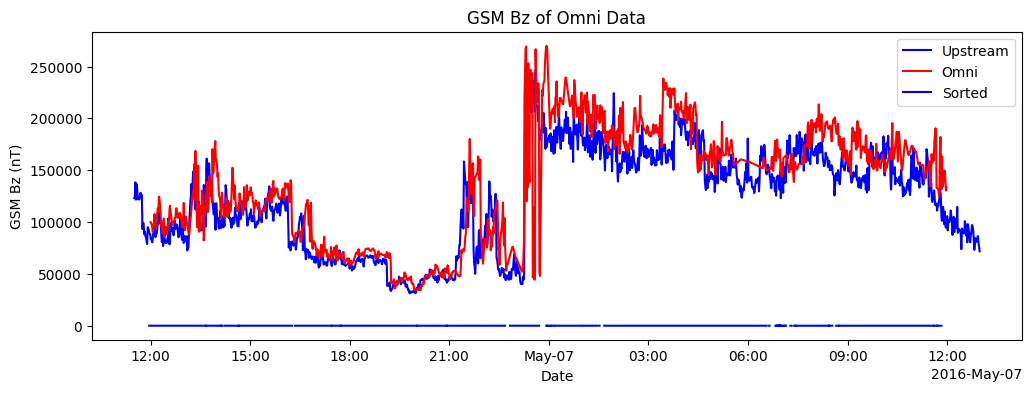

In [131]:
fig, ax = plt.subplots(figsize = (12,4))


plt.plot(ace2['Time']+pd.Timedelta(minutes=59.5), ace2['Temp'], label='Upstream', color='blue', linestyle='-')
plt.plot(omni['Time'], omni['Temp'], label='Omni', color='red', linestyle='-')
#plt.scatter(omni['Time'], omni['BZ'], c=omni['IMF'], cmap='viridis')
plt.plot(upstream_wind['Time']+pd.Timedelta(minutes=59.5), upstream_wind['BX'], label='Sorted', color='blue', linestyle='-')
#plt.scatter(upstream_wind['Time']+pd.Timedelta(minutes=59.5), upstream_wind['BZ'], c=upstream_wind['ID'], cmap='viridis')
#plt.plot(ace['Time']+pd.Timedelta(minutes=59.5), ace['BZ'], label='Ace', color='blue', linestyle='-')


plt.title('GSM Bz of Omni Data')
plt.xlabel('Date')
plt.ylabel('GSM Bz (nT)')

plt.legend()
#plt.colorbar()


#plt.xlim(dt.datetime.strptime("2016-05-06/22:00:00", "%Y-%m-%d/%H:%M:%S"), dt.datetime.strptime("2016-05-07/2:00:00", "%Y-%m-%d/%H:%M:%S"))

plt.show()

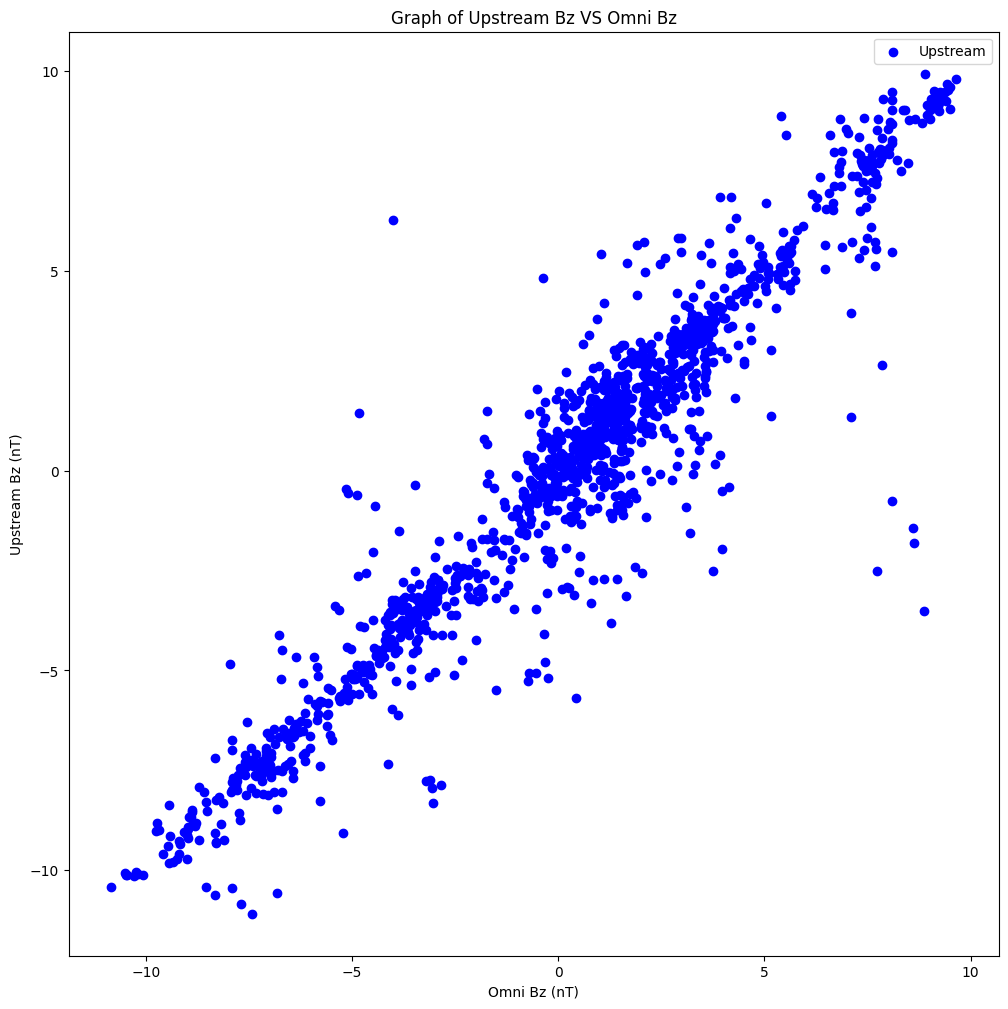

In [129]:
fig, ax = plt.subplots(figsize = (12,12))

plt.scatter(omni['BY'], upstream_wind['BY'], label='Upstream', color='blue')

plt.xlabel('Omni Bz (nT)')
plt.ylabel('Upstream Bz (nT)')
plt.title('Graph of Upstream Bz VS Omni Bz')


plt.legend()
plt.show()


Uploading Data to the web

In [117]:
upstream_wind.to_csv('upstream_output.csv', index=False)

In [118]:
tplot(omni['Temp'])

24-Nov-25 02:02:51: tplot_wildcard_expand: bad input: 0        99924.0
1        98604.0
2        98240.0
3        94350.0
4        90538.0
          ...   
1435    149571.0
1436    149571.0
1437    139953.0
1438    130335.0
1439    133362.0
Name: Temp, Length: 1440, dtype: float32 Patterns must be a string or int
24-Nov-25 02:02:51: wildcard_expand: empty pattern list
24-Nov-25 02:02:51: tplot: No matching tplot names were found


In [120]:
tplot(ace2['Temp'])

24-Nov-25 02:03:14: tplot_wildcard_expand: bad input: 0        123056.000000
1        123063.835938
2        123071.664062
3        123079.500000
4        123087.328125
             ...      
91707     72056.007812
91708     71977.851562
91709     71899.703125
91710     71821.546875
91711     71743.398438
Name: Temp, Length: 91712, dtype: float32 Patterns must be a string or int
24-Nov-25 02:03:14: wildcard_expand: empty pattern list
24-Nov-25 02:03:14: tplot: No matching tplot names were found


Right now the variables that work are BY, BZ, VX,VY,VZ, Omni doesnt have BX, NP. and I dont know if Temp is right